# Streaming in LLM based app - using Langgraph

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()


from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list,add_messages]

In [2]:
from langchain_groq import  ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

In [3]:
from langchain_tavily import TavilySearch

searchTool=TavilySearch(max_results=2)
searchTool.invoke("What is LangGraph?")

{'query': 'What is LangGraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - IBM',
   'url': 'https://www.ibm.com/think/topics/langgraph',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling 

In [4]:
## custom function  -
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): First number.
        b (int): Second number.

    Returns:
        int: Product of a and b. (output int)
    """
    return a*b

In [5]:
tools=[searchTool,multiply]

In [6]:
llm_with_tool=llm.bind_tools(tools)

In [7]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10b0f67b0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10b0f7380>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to 

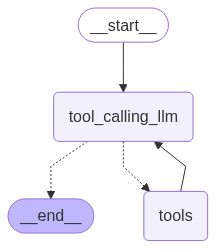

In [8]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
config={"configurable":{"thread_id":"2"}}

#stream_mode="updates" # will return the updates as they are generated
#stream_mode="final" # will return the final response only
#stream_mode="values" # will return the final response only, but as a value object
#stream_mode="tokesn" # will return the tokens as they are generated
response=graph.stream({"messages":"Hi my name is Gaurav and i like cricket as well as volleyball."},config=config,stream_mode="updates")

for update in response:
    print(update)

{'tool_calling_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '0kyynby4f', 'function': {'arguments': '{"query":"Gaurav likes cricket and volleyball"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 3608, 'total_tokens': 3654, 'completion_time': 0.078474924, 'prompt_time': 0.401110349, 'queue_time': 0.27528830800000004, 'total_time': 0.479585273}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--68704e14-ea49-429f-977a-abf5ecc893c3-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Gaurav likes cricket and volleyball'}, 'id': '0kyynby4f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 3608, 'output_tokens': 46, 'total_tokens': 3654})]}}
{'tools': {'messages': [ToolMessage(content='{"query": "Gaurav likes cricket and volleyball", "follow_up_questions": null, "answer": null, "i

In [26]:
config={"configurable":{"thread_id":"3"}}

#stream_mode="updates" # will return the updates as they are generated
#stream_mode="values" # will return the final response only, but as a value object
#stream_mode="messages" # will return the tokens as they are generated        # To stream tokens as they are produced by the LLM
async for chunk in graph.astream({"messages":"Give me latest news on iran-israel war."},config=config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Give me latest news on iran-israel war.', additional_kwargs={}, response_metadata={}, id='a47ad8cc-c74a-4a5c-ad85-a255f8ed680b')]}
{'messages': [HumanMessage(content='Give me latest news on iran-israel war.', additional_kwargs={}, response_metadata={}, id='a47ad8cc-c74a-4a5c-ad85-a255f8ed680b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '3d5xyk81w', 'function': {'arguments': '{"query":"latest news on iran-israel war","search_depth":"advanced","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 157, 'prompt_tokens': 2199, 'total_tokens': 2356, 'completion_time': 0.294063646, 'prompt_time': 0.950040185, 'queue_time': 0.27343754900000006, 'total_time': 1.2441038309999999}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--498e9338-292e-45bf-b817-4dde13f1beff-0', too

In [30]:
for chunk in graph.stream({"messages": "ice cream"},config=config,stream_mode="debug"):
    print(chunk)

{'type': 'checkpoint', 'timestamp': '2025-06-26T07:39:56.041149+00:00', 'step': 4, 'payload': {'config': {'tags': [], 'metadata': ChainMap({'thread_id': '3'}), 'callbacks': None, 'recursion_limit': 25, 'configurable': {'checkpoint_ns': '', 'thread_id': '3', 'checkpoint_id': '1f05260c-136b-65da-8004-7027891002ad'}}, 'parent_config': {'tags': [], 'metadata': ChainMap({'thread_id': '3'}), 'callbacks': None, 'recursion_limit': 25, 'configurable': {'checkpoint_ns': '', 'thread_id': '3', 'checkpoint_id': '1f052603-346f-629e-8003-19a64eb5bc3e'}}, 'values': {'messages': [HumanMessage(content='Give me latest news on iran-israel war.', additional_kwargs={}, response_metadata={}, id='a47ad8cc-c74a-4a5c-ad85-a255f8ed680b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '3d5xyk81w', 'function': {'arguments': '{"query":"latest news on iran-israel war","search_depth":"advanced","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'t

/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/threading.py:303: RuntimeWarning: coroutine 'main' was never awaited
  def __enter__(self):


{'type': 'task_result', 'timestamp': '2025-06-26T07:40:05.612478+00:00', 'step': 6, 'payload': {'id': '977010dc-ace6-d546-15b8-a02cf2be5650', 'name': 'tool_calling_llm', 'error': None, 'result': [('messages', [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '78kwmajhf', 'function': {'arguments': '{"a":1,"b":1}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 3161, 'total_tokens': 3197, 'completion_time': 0.026759231, 'prompt_time': 0.347232361, 'queue_time': 0.27119705400000005, 'total_time': 0.373991592}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8af39bf2ae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0b8aa50e-8eab-4b0c-b41c-6863e3b210b1-0', tool_calls=[{'name': 'multiply', 'args': {'a': 1, 'b': 1}, 'id': '78kwmajhf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 3161, 'output_tokens': 36, 'total_tokens': 3197})])], 'interrupts': []}}
{'type': 'checkpoint',

In [32]:
for chunk in graph.stream({"messages": "What is the response and reaction of indian government on that"},subgraphs=True,config=config,stream_mode="debug"):
    print(chunk)

((), {'type': 'checkpoint', 'timestamp': '2025-06-26T09:08:01.938204+00:00', 'step': 14, 'payload': {'config': {'tags': [], 'metadata': ChainMap({'thread_id': '3'}), 'callbacks': None, 'recursion_limit': 25, 'configurable': {'checkpoint_ns': '', 'thread_id': '3', 'checkpoint_id': '1f0526d0-fda9-67cc-800e-9d4ec698685f'}}, 'parent_config': {'tags': [], 'metadata': ChainMap({'thread_id': '3'}), 'callbacks': None, 'recursion_limit': 25, 'configurable': {'checkpoint_ns': '', 'thread_id': '3', 'checkpoint_id': '1f052610-febd-6a84-800d-c214ca993c7d'}}, 'values': {'messages': [HumanMessage(content='Give me latest news on iran-israel war.', additional_kwargs={}, response_metadata={}, id='a47ad8cc-c74a-4a5c-ad85-a255f8ed680b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '3d5xyk81w', 'function': {'arguments': '{"query":"latest news on iran-israel war","search_depth":"advanced","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metada

In [35]:
async for chunk in graph.astream_events({"messages":"Give me latest news on iran-israel war."},config,version="v2"):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Give me latest news on iran-israel war.'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '2f58aded-1375-4e19-a2c7-a3fe208a8d32', 'metadata': {'thread_id': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Give me latest news on iran-israel war.', additional_kwargs={}, response_metadata={}, id='a47ad8cc-c74a-4a5c-ad85-a255f8ed680b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '3d5xyk81w', 'function': {'arguments': '{"query":"latest news on iran-israel war","search_depth":"advanced","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 157, 'prompt_tokens': 2199, 'total_tokens': 2356, 'completion_time': 0.294063646, 'prompt_time': 0.950040185, 'queue_time': 0.27343754900000006, 'total_time': 1.2441038309999999}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_